In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import *
import matplotlib.pyplot as plt



In [19]:
# grab a pre-split curated dataset that is 50% of original data
y = pd.read_csv('train50.csv', sep=',',low_memory=False)
x = y[['PCHANGE', 'GENE', 'Domain', 'ClinicalSignificance','EFFECT', 'Civic_Evidence', 'CATEGORIZATION', 'FAF', 'GNOMAD_AC', 'GNOMAD_AF', 'EXON_Rank', 'COSMIC_CNT','MVP_score', 'Civic_Drug', 'PMID_COUNT', 'KEGG']]
train_df = x.copy()

In [23]:
train_df.fillna(-999, inplace=True)

In [24]:
X = train_df.drop('CATEGORIZATION', axis=1)
y = train_df.CATEGORIZATION

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.5, random_state=1234)
print('length of Xtrain and Xtest: ', len(X_train), len(X_validation))
print('length of ytrain and ytest: ', len(y_train), len(y_validation))

In [26]:
categorical_names = ['PCHANGE','GENE','Domain','ClinicalSignificance','EFFECT', 'Civic_Evidence']
cat_features = [train_df.columns.get_loc(i) for i in categorical_names]

In [ ]:
# run 5fold cross to find optimal itterations
roc_file='roc500_5fold.csv'
params = {}
params['loss_function'] = 'MultiClass'
params['iterations'] = 500
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['roc_file']= roc_file

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=1
)

In [ ]:
ms = pd.read_csv('roc500_5fold.csv', sep='\t',low_memory=False)


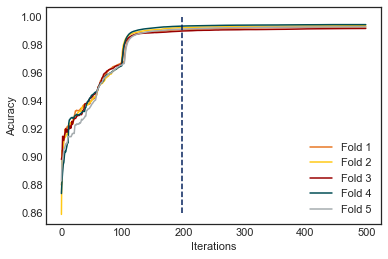

In [5]:
plt.style.use('seaborn-white')
# plot training accuracy
x = [198, 198]
y = [0.86,1.00]
plt.rcParams['font.size'] = 11

plt.plot(ms['Iterations'], ms['Fold1'],color='#E87722', label='Fold 1')
plt.plot(ms['Iterations'], ms['Fold2'],color='#ffc915', label='Fold 2')
plt.plot(ms['Iterations'], ms['Fold3'],color='#990000', label='Fold 3')
plt.plot(ms['Iterations'], ms['Fold4'],color='#004C54', label='Fold 4')
plt.plot(ms['Iterations'], ms['Fold5'],color='#A5ACAF', label='Fold 5')
#plt.plot(ms['Iterations'], ms['Final'],color='#011F5b', label='Azurify')
plt.plot(x, y, linestyle='--', color='#011F5b')
# title
#plt.title('Previously Unobserved Disease Precision-Recall curve')
# x label
plt.xlabel('Iterations')
# y label
plt.ylabel('Acuracy')
plt.rcParams["figure.figsize"] = (7.75,6)
plt.legend(loc='best')
plt.savefig('Model_Accuracy_Itterations',dpi=600)
plt.show();

In [ ]:
#run at proper itterations
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=43,
    learning_rate=0.3,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=True,
    plot=True
)


In [13]:
model_with_early_stop.save_model('azurify.json', format='json')

In [ ]:
df = model_with_early_stop.get_feature_importance(prettified=True)